<a href="https://colab.research.google.com/github/vikramkrishnan9885/MyColab/blob/master/MultiImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

http://www.image-net.org/

We'll use the STL-10 dataset provided in the PyTorch torchvision package. There are 10 classes in the dataset:

* Airplane: 0
* Bird: 1
* Car: 2
* Cat: 3
* Deer: 4
* Dog: 5
* Horse:6
* Monkey: 7
* Ship: 8
* Truck: 9

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms
import os

path2data="./data"
if not os.path.exists(path2data):
    os.mkdir(path2data)
    
data_transformer = transforms.Compose([transforms.ToTensor()])
train_ds=datasets.STL10(path2data, split='train', 
                        download=True,transform=data_transformer)
print(train_ds.data.shape)

Extracting ./data/stl10_binary.tar.gz to ./data
(5000, 3, 96, 96)


In [3]:
import collections

y_train=[y for _,y in train_ds]
counter_train=collections.Counter(y_train)
print(counter_train)

Counter({1: 500, 5: 500, 6: 500, 3: 500, 9: 500, 7: 500, 4: 500, 8: 500, 0: 500, 2: 500})


In [4]:
test0_ds=datasets.STL10(
    path2data, 
    split='test', 
    download=True,
    transform=data_transformer
)
print(test0_ds.data.shape)

Files already downloaded and verified
(8000, 3, 96, 96)


In [5]:
# Next, split the indices of test0_ds into two groups:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

indices=list(range(len(test0_ds)))
y_test0=[y for _,y in test0_ds]
for test_index, val_index in sss.split(indices, y_test0):
    print("test:", test_index, "val:", val_index)
    print(len(val_index),len(test_index))

test: [2096 4321 2767 ... 3206 3910 2902] val: [6332 6852 1532 ... 5766 4469 1011]
1600 6400


In [0]:
# Then create two datasets from test0_ds:
from torch.utils.data import Subset

val_ds=Subset(test0_ds,val_index)
test_ds=Subset(test0_ds,test_index)

In [7]:
# Next, count the number of images per class in val_ds and test_ds:
import collections
import numpy as np

y_test=[y for _,y in test_ds]
y_val=[y for _,y in val_ds]

counter_test=collections.Counter(y_test)
counter_val=collections.Counter(y_val)
print(counter_test)
print(counter_val)

Counter({6: 640, 0: 640, 4: 640, 5: 640, 9: 640, 2: 640, 3: 640, 1: 640, 7: 640, 8: 640})
Counter({2: 160, 8: 160, 3: 160, 6: 160, 4: 160, 1: 160, 5: 160, 9: 160, 0: 160, 7: 160})


In [0]:
# Let's show a few sample images from train_ds. We will import the required packages:
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

np.random.seed(0)

In [9]:
# Now, we will define the helper function:

def show(img,y=None,color=True):
    npimg = img.numpy()
    npimg_tr=np.transpose(npimg, (1,2,0))
    plt.imshow(npimg_tr)
    if y is not None:
        plt.title("label: "+str(y))

# Then pick random samples:
grid_size=4
rnd_inds=np.random.randint(0,len(train_ds),grid_size)
print("image indices:",rnd_inds)

image indices: [2732 2607 1653 3264]


In [10]:
# We will create a grid from the sample images:

x_grid=[train_ds[i][0] for i in rnd_inds]
y_grid=[train_ds[i][1] for i in rnd_inds]

x_grid=utils.make_grid(x_grid, nrow=4, padding=1)
print(x_grid.shape)

torch.Size([3, 98, 389])


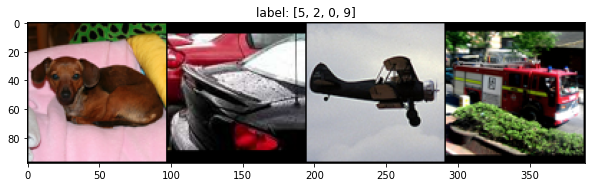

In [11]:
# Then, we will call the helper function to display the grid:

# call helper function
plt.figure(figsize=(10,10))
show(x_grid,y_grid)

image indices: [ 684  559 1216  835]
torch.Size([3, 100, 394])


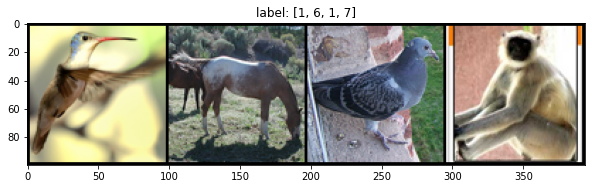

In [12]:
# Let's show sample images from validation dataset val_ds:
np.random.seed(0)

grid_size=4
rnd_inds=np.random.randint(0,len(val_ds),grid_size)
print("image indices:",rnd_inds)

x_grid=[val_ds[i][0] for i in rnd_inds]
y_grid=[val_ds[i][1] for i in rnd_inds]

x_grid=utils.make_grid(x_grid, nrow=4, padding=2)
print(x_grid.shape)

plt.figure(figsize=(10,10))
show(x_grid,y_grid)

In [13]:
# Let's calculate the mean and standard deviation of train_ds:
import numpy as np

meanRGB=[np.mean(x.numpy(),axis=(1,2)) for x,_ in train_ds]
stdRGB=[np.std(x.numpy(),axis=(1,2)) for x,_ in train_ds]

meanR=np.mean([m[0] for m in meanRGB])
meanG=np.mean([m[1] for m in meanRGB])
meanB=np.mean([m[2] for m in meanRGB])

stdR=np.mean([s[0] for s in stdRGB])
stdG=np.mean([s[1] for s in stdRGB])
stdB=np.mean([s[2] for s in stdRGB])

print(meanR,meanG,meanB)
print(stdR,stdG,stdB)

0.4467106 0.43980986 0.40664646
0.22414584 0.22148906 0.22389975


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image indices: [2732 2607 1653 3264]
torch.Size([3, 100, 394])


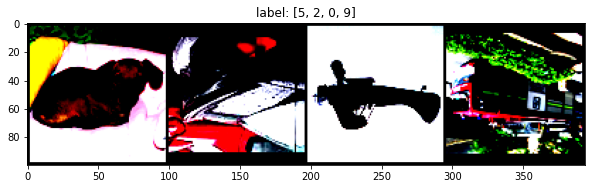

In [14]:
# Let's define the image transformations for train_ds and test0_ds:
train_transformer = transforms.Compose(
    [
      transforms.RandomHorizontalFlip(p=0.5),  
      transforms.RandomVerticalFlip(p=0.5),  
      transforms.ToTensor(),
      transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB])
    ]
)
                 

test0_transformer = transforms.Compose(
    [
      transforms.ToTensor(),
      transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB]),
    ]
)  

# Update the transform functions of train_ds and test0_ds:
train_ds.transform=train_transformer
test0_ds.transform=test0_transformer

# Next, we will display the transformed sample images from train_ds:
import torch
np.random.seed(0)
torch.manual_seed(0)

grid_size=4
rnd_inds=np.random.randint(0,len(train_ds),grid_size)
print("image indices:",rnd_inds)

x_grid=[train_ds[i][0] for i in rnd_inds]
y_grid=[train_ds[i][1] for i in rnd_inds]

x_grid=utils.make_grid(x_grid, nrow=4, padding=2)
print(x_grid.shape)

plt.figure(figsize=(10,10))
show(x_grid,y_grid)

In [15]:
# Let's create dataloaders from train_ds and val_ds:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False)  

# Then get a batch of data from train_dl:
for x, y in train_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([32, 3, 96, 96])
torch.Size([32])


In [16]:
# Next, get a batch of data from val_dl:
# extract a batch from validation data
for x, y in val_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 3, 96, 96])
torch.Size([64])


In [17]:
# We will load a pre-trained model and visualize the convolutional layers in the first layer:

# Let's import the resnet18 model with random weights from torchvision.models:
from torchvision import models
import torch

model_resnet18 = models.resnet18(pretrained=False)

# Let's print the model:
print(model_resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
# Let's change the output layer to 10 classes:
from torch import nn

num_classes=10
num_ftrs = model_resnet18.fc.in_features 
model_resnet18.fc = nn.Linear(num_ftrs, num_classes)

device = torch.device("cuda:0")
model_resnet18.to(device)

# Let's get the model summary:
from torchsummary import summary
summary(model_resnet18,input_size=(3,224,224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 7, 7])
0.0 1.1186091899871826
torch.Size([3, 65, 65])


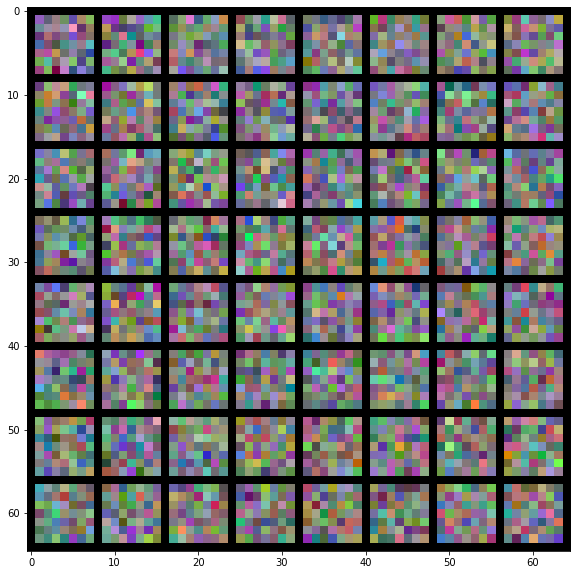

In [19]:
# Let's visualize the filters of the first CNN layer:

# Let's get the weights of the first layer:
for w in model_resnet18.parameters():
    w=w.data.cpu()
    print(w.shape)
    break

# Then, normalize the weights:
min_w=torch.min(w)
w1 = (-1/(2*min_w))*w + 0.5 
print(torch.min(w1).item(),torch.max(w1).item())

# Next, make a grid and display it:
grid_size=len(w1)
x_grid=[w1[i] for i in range(grid_size)]
x_grid=utils.make_grid(x_grid, nrow=8, padding=1)
print(x_grid.shape)

plt.figure(figsize=(10,10))
show(x_grid)

In [20]:
# Let's load resnet18 with the pre-trained weights:
from torchvision import models
import torch

resnet18_pretrained = models.resnet18(pretrained=True)

num_classes=10
num_ftrs = resnet18_pretrained.fc.in_features
resnet18_pretrained.fc = nn.Linear(num_ftrs, num_classes)

device = torch.device("cuda:0")
resnet18_pretrained.to(device) 

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 7, 7])
0.0 1.102618932723999
torch.Size([3, 65, 65])


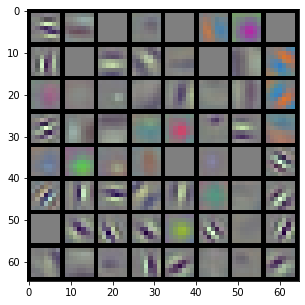

In [28]:
# get Conv1 weights
for w in resnet18_pretrained.parameters():
    w=w.data.cpu()
    print(w.shape)
    break

# normalize to [0,1]
min_w=torch.min(w)
w1 = (-1/(2*min_w))*w + 0.5 
print(torch.min(w1).item(),torch.max(w1).item())

# make a grid
grid_size=len(w1)
x_grid=[w1[i] for i in range(grid_size)]
x_grid=utils.make_grid(x_grid, nrow=8, padding=1)
print(x_grid.shape)

# call helper function
plt.figure(figsize=(5,5))
show(x_grid)

In [24]:
# Define the loss function as the following:
loss_func = nn.CrossEntropyLoss(reduction="sum")

# Let's see the loss in an example:
torch.manual_seed(0)

n,c=4,5
y = torch.randn(n, c, requires_grad=True)
print(y.shape)

loss_func = nn.CrossEntropyLoss(reduction="sum")
target = torch.randint(c,size=(n,))
print(target.shape)

loss = loss_func(y, target)
print(loss.item())

torch.Size([4, 5])
torch.Size([4])
7.312585353851318


In [25]:
# Let's compute the gradients of loss with respect to y:
loss.backward()
print (y.data)

tensor([[-1.1258, -1.1524, -0.2506, -0.4339,  0.5988],
        [-1.5551, -0.3414,  1.8530,  0.4681, -0.1577],
        [ 1.4437,  0.2660,  1.3894,  1.5863,  0.9463],
        [-0.8437,  0.9318,  1.2590,  2.0050,  0.0537]])


In [26]:
# Define an Adam optimizer object with a learning rate of 1e-4:
from torch import optim
opt = optim.Adam(model_resnet18.parameters(), lr=1e-4)

# We can read the current value of the learning rate using the following function:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

current_lr=get_lr(opt)
print('current lr={}'.format(current_lr))

current lr=0.0001


In [30]:
# Define a learning scheduler using the CosineAnnealingLR method:
from torch.optim.lr_scheduler import CosineAnnealingLR

lr_scheduler = CosineAnnealingLR(opt,T_max=2,eta_min=1e-5)

lrs=[]

# Let's see how the learning rate schedule works using the following example:
for i in range(10):
    lr_scheduler.step()
    lr=get_lr(opt)
    print("epoch %s, lr: %.1e" %(i,get_lr(opt)))   
    lrs.append(lr)

epoch 0, lr: 5.5e-05
epoch 1, lr: 1.0e-05
epoch 2, lr: 5.5e-05
epoch 3, lr: 1.0e-04
epoch 4, lr: 5.5e-05
epoch 5, lr: 1.0e-05
epoch 6, lr: 5.5e-05
epoch 7, lr: 1.0e-04
epoch 8, lr: 5.5e-05
epoch 9, lr: 1.0e-05


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


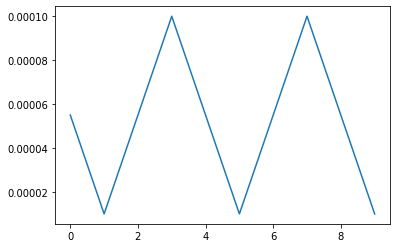

In [31]:
plt.plot(lrs)

In [0]:
# Training and Transfer Learning

def metrics_batch(output, target):
    # get output class
    pred = output.argmax(dim=1, keepdim=True)
    
    # compare output class with target class
    corrects=pred.eq(target.view_as(pred)).sum().item()
    return corrects

def loss_batch(loss_func, output, target, opt=None):
    
    # get loss 
    loss = loss_func(output, target)
    
    # get performance metric
    metric_b = metrics_batch(output,target)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# define device as a global variable
device = torch.device("cuda")

def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        
        # get model output
        output=model(xb)
        
        # get loss per batch
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt)
        
        # update running loss
        running_loss+=loss_b
        
        # update running metric
        if metric_b is not None:
            running_metric+=metric_b

        # break the loop in case of sanity check
        if sanity_check is True:
            break
    
    # average loss value
    loss=running_loss/float(len_data)
    
    # average metric value
    metric=running_metric/float(len_data)
    
    return loss, metric


def train_val(model, params):
    # extract model parameters
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    # history of loss values in each epoch
    loss_history={
        "train": [],
        "val": [],
    }
    
    # histroy of metric values in each epoch
    metric_history={
        "train": [],
        "val": [],
    }
    
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # initialize best loss to a large value
    best_loss=float('inf')
    
    # main loop
    for epoch in range(num_epochs):
        
        # get current learning rate
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))
        
        # train model on training dataset
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)

        # collect loss and metric for training dataset
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        # evaluate model on validation dataset    
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)
        
       
        # store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
        
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # learning rate schedule
        lr_scheduler.step()

        print("train loss: %.6f, dev loss: %.6f, accuracy: %.2f" %(train_loss,val_loss,100*val_metric))
        print("-"*10) 

    # load best model weights
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history


For training you have two choices:
* Random-Init weights
* Pre-Trained Weights
`

In [34]:
# Train With Random-Init Weights

import copy

loss_func = nn.CrossEntropyLoss(reduction="sum")
opt = optim.Adam(model_resnet18.parameters(), lr=1e-4)
lr_scheduler = CosineAnnealingLR(opt,T_max=5,eta_min=1e-6)

params_train={
 "num_epochs": 3,
 "optimizer": opt,
 "loss_func": loss_func,
 "train_dl": train_dl,
 "val_dl": val_dl,
 "sanity_check": False,
 "lr_scheduler": lr_scheduler,
 "path2weights": "resnet18.pt",
}

# train and validate the model
model_resnet18,loss_hist,metric_hist=train_val(model_resnet18,params_train)

Epoch 0/2, current lr=0.0001
Copied best model weights!
train loss: 1.657903, dev loss: 1.528836, accuracy: 40.75
----------
Epoch 1/2, current lr=9.05463412215599e-05
Copied best model weights!
train loss: 1.417806, dev loss: 1.497144, accuracy: 43.00
----------
Epoch 2/2, current lr=6.57963412215599e-05
Copied best model weights!
train loss: 1.220412, dev loss: 1.443978, accuracy: 45.31
----------


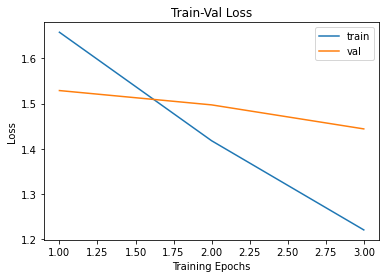

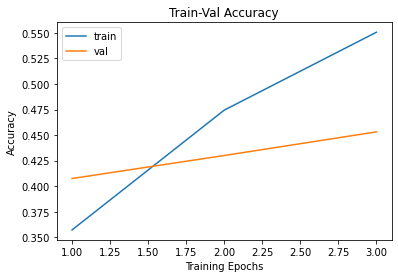

In [35]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [37]:
# Train With Pre-Trained Weights

import copy

loss_func = nn.CrossEntropyLoss(reduction="sum")
opt = optim.Adam(resnet18_pretrained.parameters(), lr=1e-4)
lr_scheduler = CosineAnnealingLR(opt,T_max=5,eta_min=1e-6)

params_train={
 "num_epochs": 3,
 "optimizer": opt,
 "loss_func": loss_func,
 "train_dl": train_dl,
 "val_dl": val_dl,
 "sanity_check": False,
 "lr_scheduler": lr_scheduler,
 "path2weights": "resnet18_pretrained.pt",
}

# train and validate the model
resnet18_pretrained,loss_hist,metric_hist=train_val(resnet18_pretrained,params_train)

Epoch 0/2, current lr=0.0001
Copied best model weights!
train loss: 0.761466, dev loss: 0.422933, accuracy: 85.19
----------
Epoch 1/2, current lr=9.05463412215599e-05
Copied best model weights!
train loss: 0.394842, dev loss: 0.388721, accuracy: 85.88
----------
Epoch 2/2, current lr=6.57963412215599e-05
Copied best model weights!
train loss: 0.289308, dev loss: 0.381899, accuracy: 86.38
----------


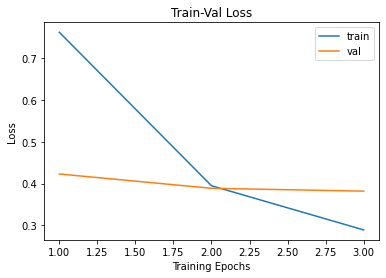

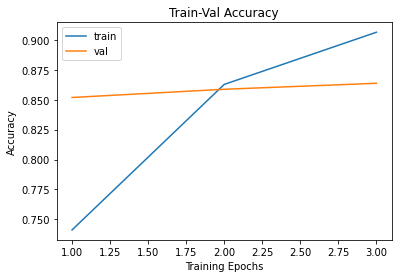

In [38]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# Deploy

In [0]:
from torch import nn
from torchvision import models
import torch

# load model
model_resnet18 = models.resnet18(pretrained=False)
num_ftrs = model_resnet18.fc.in_features
# change last layer
num_classes=10
model_resnet18.fc = nn.Linear(num_ftrs, num_classes)

 

# load state_dict into model
path2weights="resnet18_pretrained.pt"
model_resnet18.load_state_dict(torch.load(path2weights))

# set model in evaluation mode
model_resnet18.eval();


# move model to cuda/gpu device
if torch.cuda.is_available():
    device = torch.device("cuda")
    model_resnet18=model_resnet18.to(device)


def deploy_model(model,dataset,device, num_classes=10,sanity_check=False):

    len_data=len(dataset)
    
    # initialize output tensor on CPU: due to GPU memory limits
    y_out=torch.zeros(len_data,num_classes)
    
    # initialize ground truth on CPU: due to GPU memory limits
    y_gt=np.zeros((len_data),dtype="uint8")
    
    # move model to device
    model=model.to(device)
    
    elapsed_times=[]
    with torch.no_grad():
        for i in range(len_data):
            x,y=dataset[i]
            y_gt[i]=y
            start=time.time()    
            yy=model(x.unsqueeze(0).to(device))
            y_out[i]=torch.softmax(yy,dim=1)
            elapsed=time.time()-start
            elapsed_times.append(elapsed)

            if sanity_check is True:
                break

    inference_time=np.mean(elapsed_times)*1000
    print("average inference time per image on %s: %.2f ms " %(device,inference_time))
    return y_out.numpy(),y_gt

In [41]:
# Loading Test Dataset

from torchvision import datasets
import torchvision.transforms as transforms

# define transformation
data_transformer = transforms.Compose([transforms.ToTensor()])

path2data="./"

# loading data
test0_ds=datasets.STL10(path2data, split='test', download=True,transform=data_transformer)
print(test0_ds.data.shape)

Extracting ./stl10_binary.tar.gz to ./
(8000, 3, 96, 96)


In [42]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

indices=list(range(len(test0_ds)))
y_test0=[y for _,y in test0_ds]
for test_index, val_index in sss.split(indices, y_test0):
    print("test:", test_index, "val:", val_index)
    print(len(val_index),len(test_index))

test: [2096 4321 2767 ... 3206 3910 2902] val: [6332 6852 1532 ... 5766 4469 1011]
1600 6400


In [43]:
from torch.utils.data import Subset
import time
import numpy as np

val_ds=Subset(test0_ds,val_index)
test_ds=Subset(test0_ds,test_index)

mean=[0.4467106, 0.43980986, 0.40664646]
std=[0.22414584,0.22148906,0.22389975]

test0_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    ])

test0_ds.transform=test0_transformer


# deploy model 
y_out,y_gt=deploy_model(model_resnet18,val_ds,device=device,sanity_check=False)
print(y_out.shape,y_gt.shape)

average inference time per image on cuda: 7.83 ms 
(1600, 10) (1600,)


In [44]:
from sklearn.metrics import accuracy_score

# get predictions
y_pred = np.argmax(y_out,axis=1)
print(y_pred.shape,y_gt.shape)

# compute accuracy 
acc=accuracy_score(y_pred,y_gt)
print("accuracy: %.2f" %acc)

(1600,) (1600,)
accuracy: 0.86


In [45]:
y_out,y_gt=deploy_model(model_resnet18,test_ds,device=device)

y_pred = np.argmax(y_out,axis=1)
acc=accuracy_score(y_pred,y_gt)
print(acc)

average inference time per image on cuda: 7.76 ms 
0.8640625


image indices: [5157  235 3980 5192]
torch.Size([3, 100, 394])


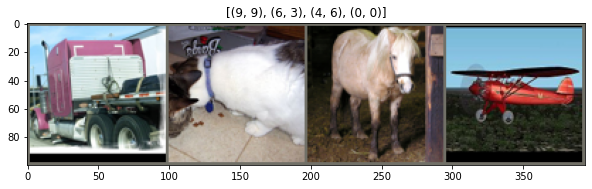

In [46]:
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
np.random.seed(1)

def imshow(inp, title=None):
    mean=[0.4467106, 0.43980986, 0.40664646]
    std=[0.22414584,0.22148906,0.22389975]
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(mean)
    std = np.array(std)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated  

grid_size=4
rnd_inds=np.random.randint(0,len(test_ds),grid_size)
print("image indices:",rnd_inds)

x_grid_test=[test_ds[i][0] for i in rnd_inds]
y_grid_test=[(y_pred[i],y_gt[i]) for i in rnd_inds]

x_grid_test=utils.make_grid(x_grid_test, nrow=4, padding=2)
print(x_grid_test.shape)

plt.rcParams['figure.figsize'] = (10, 5)
imshow(x_grid_test,y_grid_test)

In [47]:
device_cpu = torch.device("cpu")
y_out,y_gt=deploy_model(model_resnet18,val_ds,device=device_cpu,sanity_check=False)
print(y_out.shape,y_gt.shape)

average inference time per image on cpu: 24.95 ms 
(1600, 10) (1600,)
